# Learned Reconstruction

In inverse problems, we want to recover some signal $x$ from noisy measurements $y$ where we know the forward model $\mathcal{T} : \mathcal{X} \to \mathcal{Y}$
$$
    y = \mathcal{T}(x) + e
$$
In machine learning for inverse problems we aim to find some operator $\mathcal{T}_\theta^\dagger : \mathcal{Y} \to \mathcal{X}$ that inverts this process
$$
    \mathcal{T}_\theta^\dagger(y) \approx x
$$

This notebook demonstrates how to use ODL to perform learned reconstruction of the famous MNIST dataset. We demonstrate three ways of doing this

* Fully learned reconstruction
* Learned post-processing
* Learned iterative reconstruction

and we also compare to FBP-based reconstruction.

The results should be approximately

| Method                 |  Mean Error  |
|------------------------|----------|
| FBP                    | 0.01694  |
| Fully learned          | 0.00226  |
| FBP + learned denoiser | 0.00260  |
| Learned Iterative      | 0.005150 |

Note that the examples in this notebook may take some time to run, approximately 10-15 minutes each can be expected on a reasonable laptop.

**Note:** This is a pytorch port of [the notebook using tensorflow](part3_learned_reconstruction.ipynb) with reduced text, see the other notebook for more details.

In [11]:
!pip install https://github.com/odlgroup/odl/archive/master.zip

  Using cached https://github.com/odlgroup/odl/archive/master.zip
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of odl to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement matplotlib-base>=3.4 (from odl) (from versions: none)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
ERROR: No matching distribution found for matplotlib-base>=3.4


In [71]:
%matplotlib inline
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import odl
from odl.contrib.torch import OperatorModule
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch import optim
import torchvision
from torchvision import datasets, transforms
torch.manual_seed(123);  # reproducibility
import torch.nn.functional as F
import pandas as pd  # Import pandas for CSV saving
import models.aux_funs as maf
import optimizers as op
import regularizers as reg
import utils.configuration as cf
import train
import math
import pandas as pd  # For reading the CSV files
import matplotlib.pyplot as plt  # For plotting

## Get training and test data

We create loaders for the MNIST data:

In [72]:
from torch.utils.data import random_split
from torchvision import datasets, transforms
import torch

# Define the desired total subset size (e.g., 600 samples)
total_subset_size = 600  # Total samples for the subset (train + validation)
train_val_split = [500, 100]  # Split subset into 500 for training, 100 for validation
test_subset_size = 100  # Define a similar subset size for the test set

# Define transformations: convert to Tensor and normalize
trafo = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),  # Normalization based on MNIST mean and std dev
])

# Load the MNIST dataset for training and validation
dset_train_val = datasets.MNIST('./data', train=True, download=True, transform=trafo)

# Step 1: Subset the original dataset to a smaller size (600 samples in total)
subset_train_val, _ = random_split(dset_train_val, [total_subset_size, len(dset_train_val) - total_subset_size])

# Step 2: Further split the smaller subset into training and validation sets
train_dataset, val_dataset = random_split(subset_train_val, train_val_split)

# Data loaders for training and validation using the smaller dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=50, shuffle=True)

# Load the MNIST dataset for testing
dset_test = datasets.MNIST('./data', train=False, transform=trafo)

# Step 3: Subset the test set
test_subset, _ = random_split(dset_test, [test_subset_size, len(dset_test) - test_subset_size])
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=50, shuffle=True)

print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_subset)}')


Train dataset size: 500
Validation dataset size: 100
Test dataset size: 100


## Create ODL objects

We initialize the ray transform on a space suitable for the MNIST images. We also create a filtered backprojection (FBP) operator for comparison, and for the FBP denoising net later on:

In [73]:
space = odl.uniform_discr([-14, -14], [14, 14], [28, 28], dtype='float32')
geometry = odl.tomo.parallel_beam_geometry(space, num_angles=5)
fwd_op = odl.tomo.RayTransform(space, geometry)
fbp_op = odl.tomo.fbp_op(fwd_op)

## Make pytorch `Module`s from ODL operators

For use in our neural networks, we create pytorch modules from the above operators. For this we use the `OperatorAsModule` class from `odl.contrib.torch`. It implements automatic differentiation as required for backpropagation in pytorch, and it supports extra batch and channel axes.

In [74]:
fwd_op_mod = OperatorModule(fwd_op)
fwd_op_adj_mod = OperatorModule(fwd_op.adjoint)
fbp_op_mod = OperatorModule(fbp_op)

## Some helper functions

For the generation of noisy projection data and for visualization of the results we use the following helpers:

In [75]:
def generate_data(images):
    """Create noisy projection data from images.

    The data is generated according to ::

        data = fwd_op(images) + noise

    where ``noise`` is standard white noise.

    Parameters
    ----------
    images : `Variable`, shape ``(B, C, 28, 28)``
        Input images for the data generation.

    Returns
    -------
    data : `Variable`, shape ``(B, C, 5, 41)``
        Projection data stack.
    """
    torch.manual_seed(123)
    data = fwd_op_mod(images)
    data += Variable(torch.randn(data.shape)).type_as(data)
    return data


def show_image_matrix(image_batches, titles=None, indices=None, **kwargs):
    """Visualize a 2D set of images arranged in a grid.

    This function shows a 2D grid of images, where the i-th column
    shows images from the i-th batch. The typical use case is to compare
    results of different approaches with the same data, or to compare
    against a ground truth.

    Parameters
    ----------
    image_batches : sequence of `Tensor` or `Variable`
        List containing batches of images that should be displayed.
        Each tensor should have the same shape after squeezing, except
        for the batch axis.
    titles : sequence of str, optional
        Titles for the colums in the plot. By default, titles are empty.
    indices : sequence of int, optional
        Object to select the subset of the images that should be shown.
        The subsets are determined by slicing along the batch axis, i.e.,
        as ``displayed = image_batch[indices]``. The default is to show
        everything.
    kwargs :
        Further keyword arguments that are passed on to the Matplotlib
        ``imshow`` function.
    """
    import matplotlib.pyplot as plt

    if indices is None:
        displayed_batches = image_batches
    else:
        displayed_batches = [batch[indices] for batch in image_batches]

    displayed_batches = [batch.data if isinstance(batch, Variable) else batch
                         for batch in displayed_batches]

    nrows = len(displayed_batches[0])
    ncols = len(displayed_batches)

    if titles is None:
        titles = [''] * ncols

    figsize = 2
    fig, rows = plt.subplots(
        nrows, ncols, sharex=True, sharey=True,
        figsize=(ncols * figsize, figsize * nrows))

    if nrows == 1:
        rows = [rows]

    for i, row in enumerate(rows):
        if ncols == 1:
            row = [row]
        for name, batch, ax in zip(titles, displayed_batches, row):
            if i == 0:
                ax.set_title(name)
            ax.imshow(batch[i].squeeze(), **kwargs)
            ax.set_axis_off()
    plt.show()

## Generate test data

We take one batch from the test dataset and generate the corresponding test projection data for validation:

In [76]:
# Get a batch of test images and generate test projection data
for i, (images, _) in enumerate(test_loader):
    if i == 1:
        break

test_images = Variable(images)
test_data = generate_data(test_images)

## FBP reconstruction

First we make a simple FBP reconstruction and compare it to the ground truth.

Average error: tensor(0.0109)


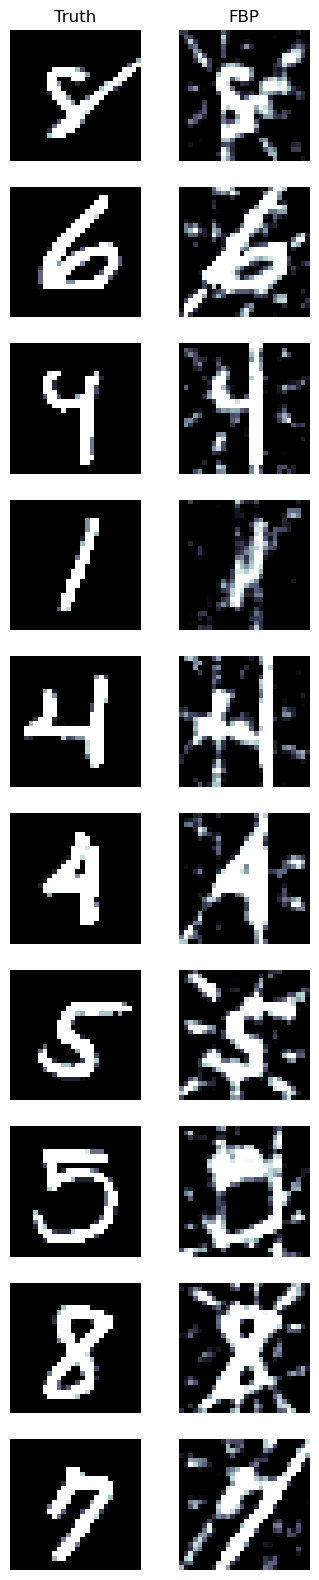

In [77]:
fbp_recos = fbp_op_mod(test_data)
print('Average error:', F.mse_loss(fbp_recos, test_images).data / len(test_images))

# Display examples
results = [test_images, fbp_recos]
titles = ['Truth', 'FBP']
show_image_matrix(results, titles, indices=slice(10, 20), clim=[0, 1], cmap='bone')

## Fully learned reconstruction

Now for the first neural network that learns how to reconstruct. We use a rather simple approach of fully connected layers at each level, gradually proceeding from size `5 * 41` to size `28 * 28`:

In [114]:
class FullRecoNet(nn.Module):
    def __init__(self):
        super(FullRecoNet, self).__init__()
        self.lin1 = nn.Linear(5 * 41, 1024)
        self.lin2 = nn.Linear(1024, 1024)
        self.lin3 = nn.Linear(1024, 28 ** 2)

    def forward(self, x):
        x = F.relu(self.lin1(x.view(-1, 5 * 41)))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x.view(-1, 1, 28, 28)

In [120]:
conf_args = {
    # optimizer
    'delta':1.0, 'lr':0.01, 'lamda_0':0.0, 'lamda_1':0.0, 'optim':"L1SGD", 'conv_group':True,
    'beta':0.0,
    # initialization
    'sparse_init':0.1, 'r':[5.,5., 5.],
}

conf = cf.Conf(**conf_args)

In [121]:

def init_weights(model):
    # sparsify
    maf.sparse_bias_uniform_(model, 0.1, 0.1, ltype=torch.nn.Linear)
    maf.sparse_weight_normal_(model, 0.1, ltype=torch.nn.Linear)
    maf.sparsify_(model, 0.4, ltype=nn.Linear, conv_group=False)
    return model


# Initialize the weights
model1 = init_weights(FullRecoNet())

print('net_sparse', maf.net_sparsity(model1))

net_sparse 0.40020433587928467


Let's train the network and see how well it does. We run 1 epoch for each model to have a somewhat fair comparison.

In [122]:
def init_opt(conf, model):
    # -----------------------------------------------------------------------------------
    # Get access to different model parameters
    # -----------------------------------------------------------------------------------
    weights_conv = maf.get_weights_conv(model)
    weights_linear = maf.get_weights_linear(model)
    biases = maf.get_bias(model)
    
    # -----------------------------------------------------------------------------------
    # Initialize optimizer
    # -----------------------------------------------------------------------------------
    if conf.conv_group:
        reg2 = reg.reg_l1_l1_l2_conv(lamda0=conf.lamda_0, lamda1=conf.lamda_1)
    else:
        reg2 = reg.reg_l1(lamda=conf.lamda_0)
    
    if conf.optim == "SGD":
        opt = torch.optim.SGD(model.parameters(), lr=conf.lr, momentum=conf.beta, weight_decay=conf.lamda_1)
    elif conf.optim == "LinBreg":
        opt = op.LinBreg([{'params': weights_conv, 'lr' : conf.lr, 'reg' : reg2, 'momentum':conf.beta,'delta':conf.delta},
                          {'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda_1), 'momentum':conf.beta,'delta':conf.delta},
                          {'params': biases, 'lr': conf.lr, 'momentum':conf.beta}])
    elif conf.optim == "L1SGD":
        def weight_reg(model):
            reg1 =  reg.reg_l1(lamda=conf.lamda_1)
        
            loss1 = reg1(model.layers2[0].weight) + reg1(model.layers2[2].weight)
            loss2 = reg2(model.layers1[0].weight) + reg2(model.layers1[3].weight)
            return loss1 + loss2
        
        conf.weight_reg = weight_reg
        
        opt = torch.optim.SGD(model.parameters(), lr=conf.lr, momentum=conf.beta)
    else:
        raise ValueError("Unknown Optimizer specified")

    # learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.7, patience=10,threshold=0.0001)
    
    return opt, scheduler


In [123]:
import os
import csv
import pandas as pd
import torch
import matplotlib.pyplot as plt

# Configuration for training
epochs = 300
loss_train = nn.MSELoss()
loss_test = nn.MSELoss()
optimizer, scheduler = init_opt(conf, model1)

# Lists to store results for later saving
epoch_list = []
val_loss_list = []
sparsity_list = []

# Formatted directory structure
save_path = os.path.join(
    'CTresult', 
    f"lr_{conf.lr}_l0_{conf.lamda_0}_l1_{conf.lamda_1}_{conf.optim}"
)
os.makedirs(save_path, exist_ok=True)

# File paths for storing results
net_sparsity_path = os.path.join(save_path, "net_sparsity.csv")
validation_loss_path = os.path.join(save_path, "validation_loss.csv")
node_sparsity_path = os.path.join(save_path, "node_sparsity.csv")

def save_epoch_results(epoch, val_data):
    """
    Save validation results for each epoch to CSV files.
    """
    # Helper function to append results to CSV
    def write_csv(file_path, headers, row):
        file_exists = os.path.isfile(file_path)
        with open(file_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            if not file_exists:
                writer.writerow(headers)
            writer.writerow(row)

    # Write net sparsity and validation loss
    write_csv(net_sparsity_path, ["Epoch", "Net Sparsity"], [epoch, val_data['Net Sparsity']])
    write_csv(validation_loss_path, ["Epoch", "Validation Loss"], [epoch, val_data['validation_loss']])

    # Write node sparsity (assuming it’s a comma-separated string)
    node_values = [float(value) for value in val_data['Node'].split(", ")]
    headers = ["Epoch"] + [f"Node_{i}" for i in range(len(node_values))]
    write_csv(node_sparsity_path, headers, [epoch] + node_values)

# Training function
def train(epoch):
    model1.train()
    train_loss = 0
    for batch_idx, (images, _) in enumerate(train_loader):
        images = Variable(images)
        projs = generate_data(images)
        optimizer.zero_grad()
        output = model1(projs)
        loss = loss_train(output, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f'Train Epoch: {epoch} | Average Loss: {avg_train_loss:.6f} | Net Sparsity: {maf.net_sparsity(model1)}')

# Validation function
def validate(epoch):
    model1.eval()
    val_loss = 0
    with torch.no_grad():
        for val_images, _ in val_loader:
            val_images = Variable(val_images)
            val_projs = generate_data(val_images)
            output = model1(val_projs)
            loss = loss_train(output, val_images)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Validation Epoch: {epoch} | Learning Rate: {current_lr:.6f} | Average Loss: {avg_val_loss:.6f}')
    return avg_val_loss

# Main training loop
for epoch in range(1, epochs + 1):
    train(epoch)
    avg_val_loss = validate(epoch)

    # Collect results
    epoch_list.append(epoch)
    val_loss_list.append(avg_val_loss)
    sparsity_list.append(maf.net_sparsity(model1))

    # Save epoch-specific results
    val_data = {
        'Net Sparsity': maf.net_sparsity(model1),
        'validation_loss': avg_val_loss,
        'Node': "0.1, 0.2, 0.3"  # Example node sparsity values, replace as needed
    }
    save_epoch_results(epoch, val_data)

    # Scheduler step if defined
    if scheduler is not None:
        scheduler.step(avg_val_loss)

# Save cumulative results to a CSV
results_df = pd.DataFrame({
    'Epoch': epoch_list,
    'Validation Loss': val_loss_list,
    'Sparsity': sparsity_list
})
results_df.to_csv(os.path.join(save_path, 'L1SGD_Recon_training_results.csv'), index=False)




Train Epoch: 1 | Average Loss: 0.991411 | Net Sparsity: 0.9854810916542474
Validation Epoch: 1 | Learning Rate: 0.010000 | Average Loss: 1.006887
Train Epoch: 2 | Average Loss: 0.991014 | Net Sparsity: 0.9878868410022354
Validation Epoch: 2 | Learning Rate: 0.010000 | Average Loss: 1.006461
Train Epoch: 3 | Average Loss: 0.990611 | Net Sparsity: 0.9879096420144063
Validation Epoch: 3 | Learning Rate: 0.010000 | Average Loss: 1.006026
Train Epoch: 4 | Average Loss: 0.990195 | Net Sparsity: 0.987935838922007
Validation Epoch: 4 | Learning Rate: 0.010000 | Average Loss: 1.005575
Train Epoch: 5 | Average Loss: 0.989764 | Net Sparsity: 0.987952333271237
Validation Epoch: 5 | Learning Rate: 0.010000 | Average Loss: 1.005103
Train Epoch: 6 | Average Loss: 0.989311 | Net Sparsity: 0.9879741640275708
Validation Epoch: 6 | Learning Rate: 0.010000 | Average Loss: 1.004605
Train Epoch: 7 | Average Loss: 0.988831 | Net Sparsity: 0.9879921137605564
Validation Epoch: 7 | Learning Rate: 0.010000 | Ave

Plotting metrics for: LR=0.1, L0=0.01, L1=0.001, OPT=LinBreg
Plotting metrics for: LR=0.01, L0=0.0, L1=0.0, OPT=L1SGD
Plotting metrics for: LR=0.01, L0=0.01, L1=0.001, OPT=L1SGD
Plotting metrics for: LR=0.1, L0=0.01, L1=0.001, OPT=LinBreg
Plotting metrics for: LR=0.01, L0=0.0, L1=0.0, OPT=L1SGD
Plotting metrics for: LR=0.01, L0=0.01, L1=0.001, OPT=L1SGD


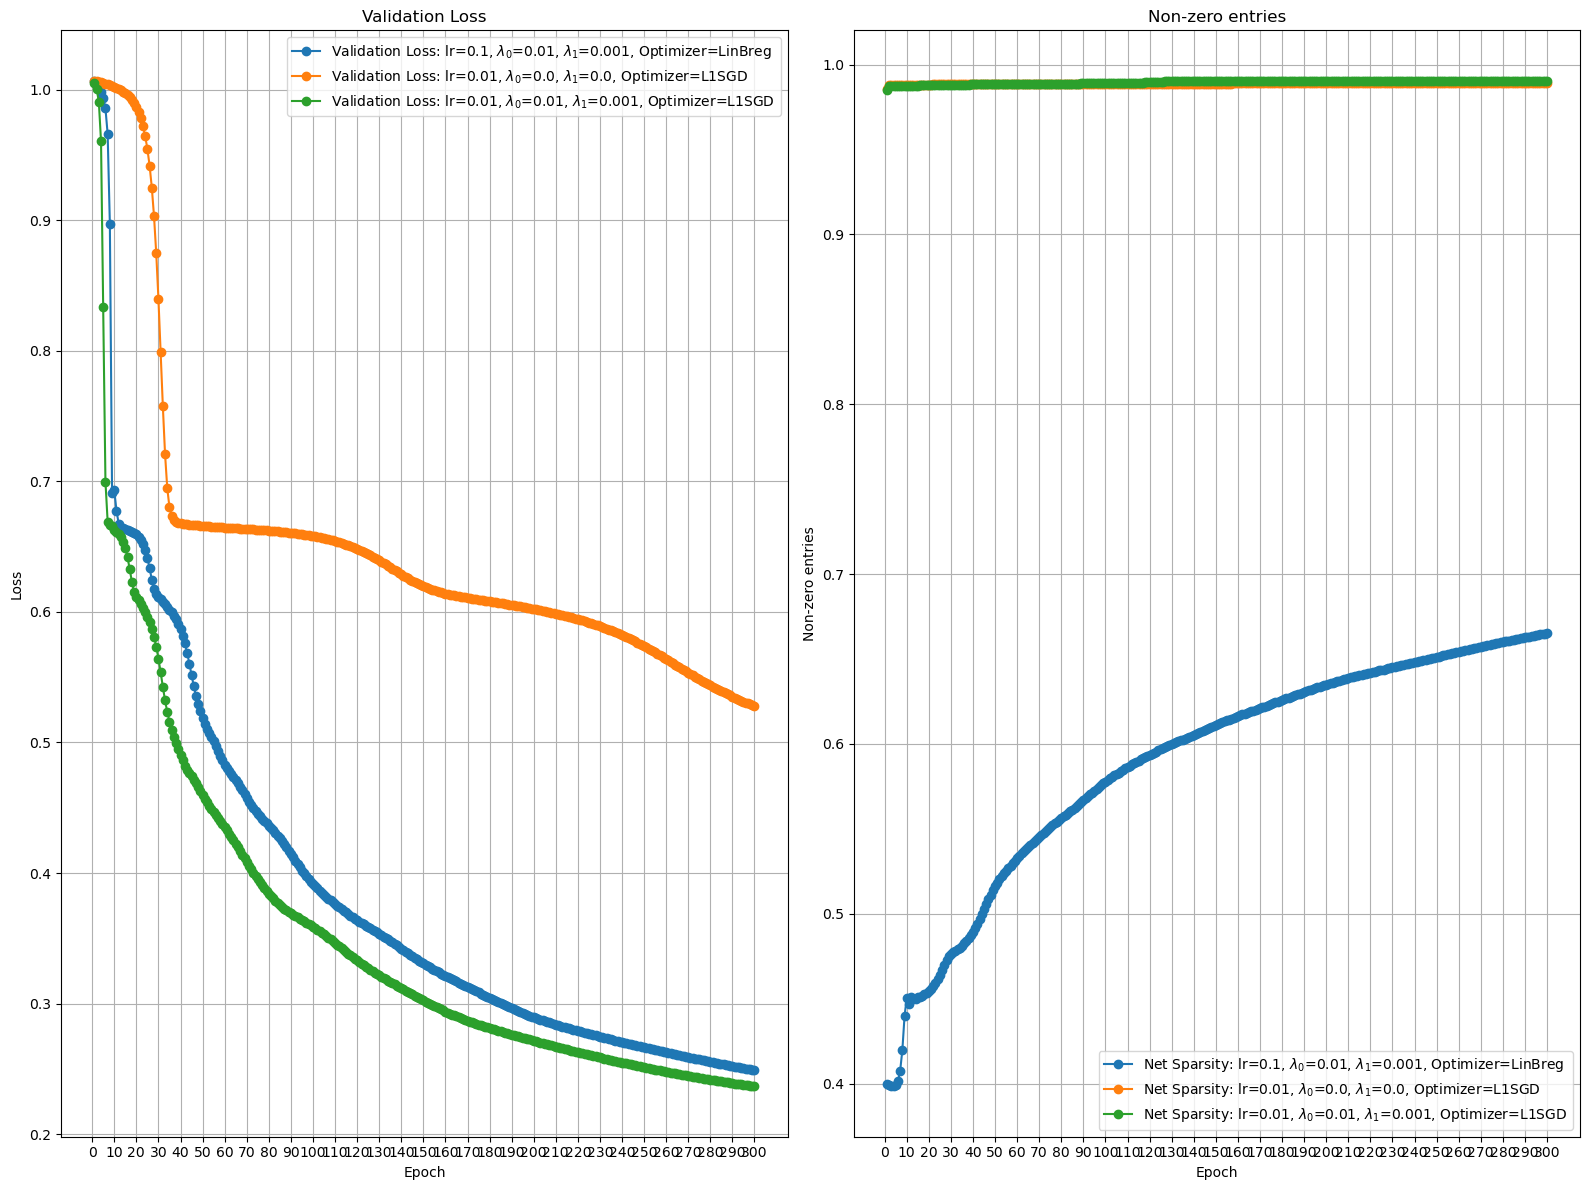

In [124]:
import os
import csv
import matplotlib.pyplot as plt

# Function to read CSV file into a dictionary
def read_csv_to_dict(file_path):
    data = {}
    with open(file_path, mode='r') as file:
        reader = csv.reader(file)
        headers = next(reader)
        for row in reader:
            epoch = int(row[0])
            value = float(row[1])
            data[epoch] = value
    return data

# Function to read node sparsity CSV file into a dictionary
def read_node_sparsity_csv(file_path):
    data = {}
    with open(file_path, mode='r') as file:
        reader = csv.reader(file)
        headers = next(reader)
        node_indices = [header.split('_')[-1] for header in headers[1:]]  # Extract node indices from headers
        for row in reader:
            epoch = int(row[0])
            values = list(map(float, row[1:]))
            for idx, node_index in enumerate(node_indices):
                if node_index not in data:
                    data[node_index] = []
                data[node_index].append(values[idx])
    return data

# Function to plot training loss
def plot_training_loss(ax, save_path, formatted_lr, formatted_lamda0, formatted_lamda1, formatted_opt):
    loss_path = os.path.join(save_path, "validation_loss.csv")
    loss_data = read_csv_to_dict(loss_path)
    
    epochs = list(loss_data.keys())
    loss_values = list(loss_data.values())
    
    ax.plot(epochs, loss_values, marker='o', linestyle='-', label=f'Validation Loss: lr={formatted_lr}, $\\lambda_0$={formatted_lamda0}, $\\lambda_1$={formatted_lamda1}, Optimizer={formatted_opt}')
    return epochs

# Function to plot net sparsity
def plot_net_sparsity(ax, save_path, formatted_lr, formatted_lamda0, formatted_lamda1, formatted_opt):
    net_path = os.path.join(save_path, "net_sparsity.csv")
    net_data = read_csv_to_dict(net_path)
    
    epochs = list(net_data.keys())
    net_values = list(net_data.values())
    
    ax.plot(epochs, net_values, marker='o', linestyle='-', label=f'Net Sparsity: lr={formatted_lr}, $\\lambda_0$={formatted_lamda0}, $\\lambda_1$={formatted_lamda1}, Optimizer={formatted_opt}')
    return epochs

# Function to create and display plots in a 2x2 grid
def create_and_display_plots_1x2(base_path):
    fig, axs = plt.subplots(1, 2, figsize=(16, 12))
    axs = axs.flatten()
    plot_functions = [plot_training_loss, plot_net_sparsity]
    titles = ['Validation Loss', 'Non-zero entries']
    ylabels = ['Loss', 'Non-zero entries']
    
    subdirectories = [name for name in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, name))]
    
    for ax, plot_function, title, ylabel in zip(axs, plot_functions, titles, ylabels):
        all_epochs = []
        for subdir in subdirectories:
            subdir_path = os.path.join(base_path, subdir)
            
            # Parse the directory name to extract parameters
            params = subdir.split('_')
            formatted_lr = params[1]
            formatted_lamda0 = params[3]
            formatted_lamda1 = params[5]
            formatted_opt = params[6]
            
            print(f"Plotting metrics for: LR={formatted_lr}, L0={formatted_lamda0}, L1={formatted_lamda1}, OPT={formatted_opt}")
            
            epochs = plot_function(ax, subdir_path, formatted_lr, formatted_lamda0, formatted_lamda1, formatted_opt)
            all_epochs.extend(epochs)
        
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xlabel('Epoch')
        ax.legend()
        ax.grid(True)
        
        if all_epochs:
            max_epoch = max(all_epochs)
            ax.set_xticks(range(0, max_epoch + 1, 10))  # Set x-axis ticks for every 10 epochs
            ax.set_xticklabels(range(0, max_epoch + 1, 10))  # Set x-axis tick labels for every 10 epochs
    
    plt.tight_layout()
    plt.show()

# Example usage
save_path = 'CTresult'
create_and_display_plots_1x2(save_path)


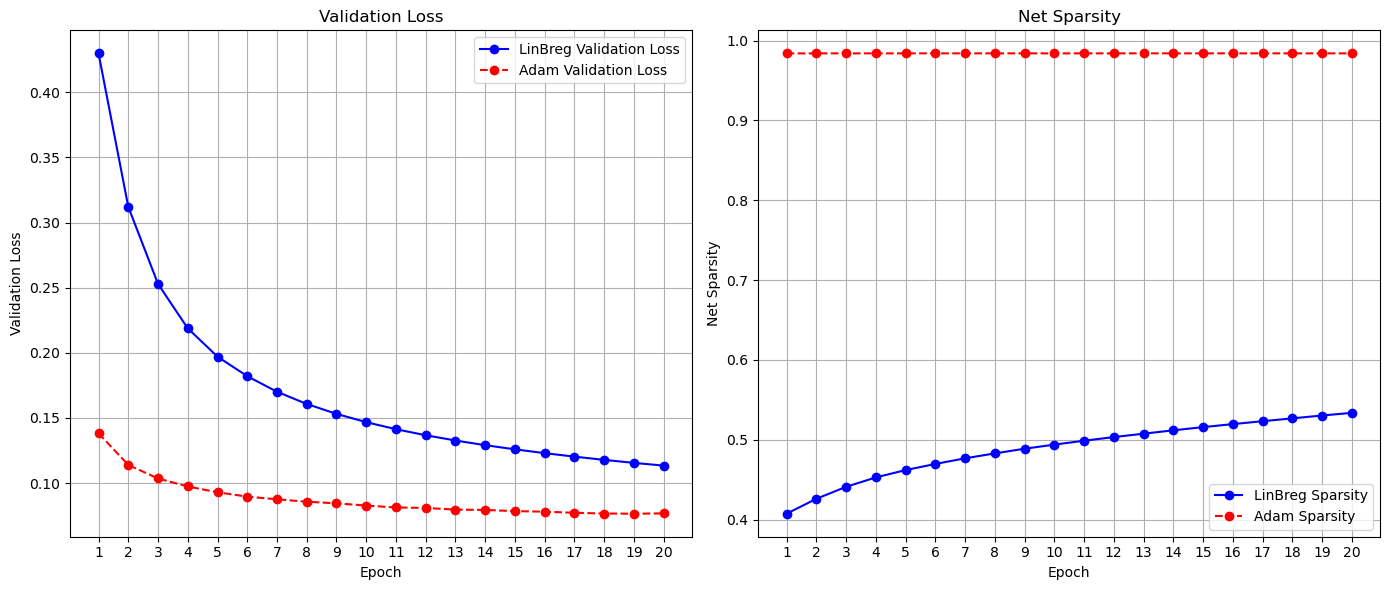

In [9]:
# Load the training results from CSV files
linbreg_results = pd.read_csv('60000Samples20Epochs/LinBreg_Recon_training_results.csv')
adam_results = pd.read_csv('60000Samples20Epochs/Adam_Recon_training_results.csv')

# Extract columns for plotting
epochs_linbreg = linbreg_results['Epoch']
val_loss_linbreg = linbreg_results['Validation Loss']
sparsity_linbreg = linbreg_results['Sparsity']

epochs_adam = adam_results['Epoch']
val_loss_adam = adam_results['Validation Loss']
sparsity_adam = adam_results['Sparsity']

# Create a figure for the plots
plt.figure(figsize=(14, 6))

# Plot 1: Validation Loss vs Epoch
plt.subplot(1, 2, 1)
plt.plot(epochs_linbreg, val_loss_linbreg, marker='o', linestyle='-', color='b', label='LinBreg Validation Loss')
plt.plot(epochs_adam, val_loss_adam, marker='o', linestyle='--', color='r', label='Adam Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.xticks(range(1, max(len(epochs_linbreg), len(epochs_adam)) + 1))  # Set x-ticks to be the epochs
plt.grid()
plt.legend()

# Plot 2: Sparsity vs Epoch
plt.subplot(1, 2, 2)
plt.plot(epochs_linbreg, sparsity_linbreg, marker='o', linestyle='-', color='b', label='LinBreg Sparsity')
plt.plot(epochs_adam, sparsity_adam, marker='o', linestyle='--', color='r', label='Adam Sparsity')
plt.title('Net Sparsity')
plt.xlabel('Epoch')
plt.ylabel('Net Sparsity')
plt.xticks(range(1, max(len(epochs_linbreg), len(epochs_adam)) + 1))  # Set x-ticks to be the epochs
plt.grid()
plt.legend()

plt.tight_layout()
plt.savefig('training_plots_comparison.png')  # Save the figure as a PNG file
plt.show()  # Show the plots

Visualizing a sample from the results in comparison to FBP:

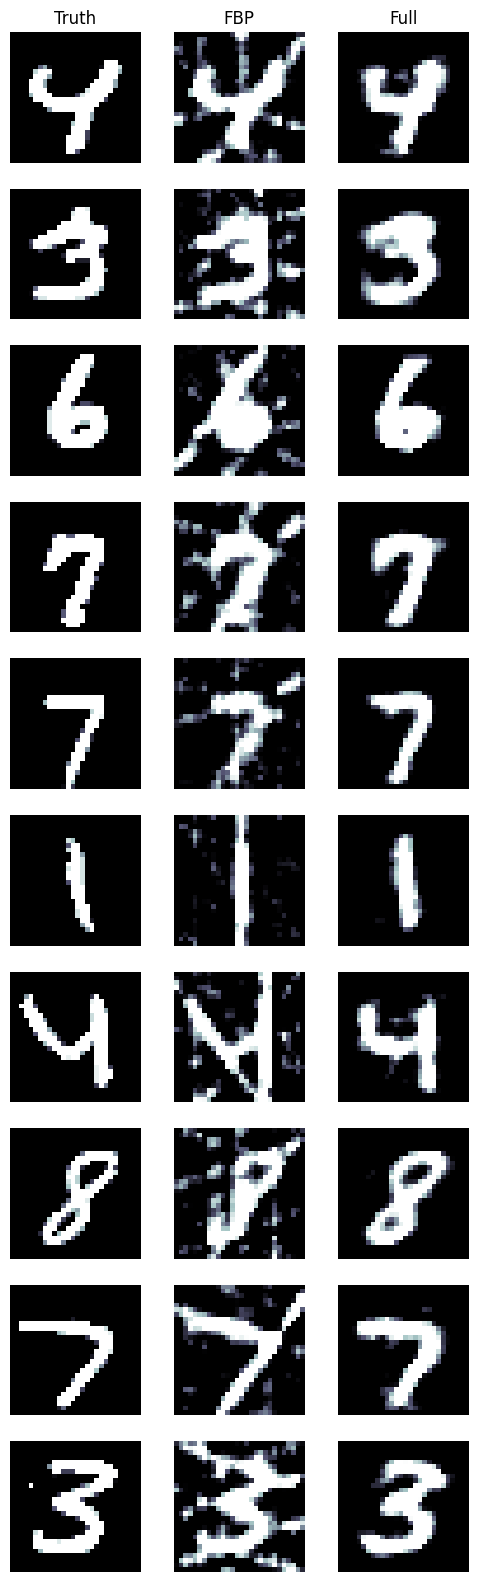

net_sparse 0.9841993836934922


In [33]:
test_res_full = model1(test_data)
results = [test_images.cpu(), fbp_recos.cpu(), test_res_full.cpu()]
titles = ['Truth', 'FBP', 'Full']
show_image_matrix(results, titles, indices=slice(10, 20), clim=[0, 1], cmap='bone')
print('net_sparse', maf.net_sparsity(model1))

These examples look much better than FBP (unsurprisingly), but there are still some issues with noise, deformations etc.

To also make an assessment about the number of trainable parameters and thus the scalability of the approach (the more parameters, the harder to train), the total number of parameters in the model can be checked like this:

In [35]:
print('Total number of parameters:',
      sum(param.numel() for param in model1.parameters()))
print('Training data size:', 600 * 28 ** 2)

Total number of parameters: 2064144
Training data size: 470400


It turns out that for this tiny problem, the number of parameters is over 2 million. This is still a good deal away from the input data size (47 million), but overfitting is likely with this network. Therefore we explore sparser architectures.

## FBP denoising net

This network operates entirely on the 28 x 28 sized image domain by taking an FBP reconstruction as input and then trying to learn how to remove the noise and the streak artefacts. It uses convolutions that have far fewer parameters.

In [55]:
class DenoisingNet(nn.Module):
    def __init__(self):
        super(DenoisingNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 1, 3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [ ]:
conf_args = {
    # optimizer
    'delta':1.0, 'lr':0.005, 'lamda_0':0.01, 'lamda_1':0.001, 'optim':"L1SGD", 'conv_group':True,
    'beta':0.9,
    # initialization
    'sparse_init':0.1, 'r':[5.,5., 5.],
}

conf = cf.Conf(**conf_args)

In [56]:
def init_weights(model):
    # sparsify
    maf.sparse_bias_uniform_(model, 0.1, 0.1, ltype=torch.nn.Conv2d)
    maf.sparse_weight_normal_(model, 0.1, ltype=torch.nn.Conv2d)
    maf.sparsify_(model, 0.4, ltype=nn.Conv2d, conv_group=False)
    return model


# Initialize the weights
model2 = init_weights(DenoisingNet())

print('net_sparse', maf.net_sparsity(model2))

net_sparse 0.4014501633986928


In [ ]:
def init_opt(conf, model):
    # -----------------------------------------------------------------------------------
    # Get access to different model parameters
    # -----------------------------------------------------------------------------------
    weights_conv = maf.get_weights_conv(model)
    weights_linear = maf.get_weights_linear(model)
    biases = maf.get_bias(model)
    
    # -----------------------------------------------------------------------------------
    # Initialize optimizer
    # -----------------------------------------------------------------------------------
    if conf.conv_group:
        reg2 = reg.reg_l1_l1_l2_conv(lamda0=conf.lamda_0, lamda1=conf.lamda_1)
    else:
        reg2 = reg.reg_l1(lamda=conf.lamda_0)
    
    if conf.optim == "SGD":
        opt = torch.optim.SGD(model.parameters(), lr=conf.lr, momentum=conf.beta, weight_decay=conf.lamda_1)
    elif conf.optim == "LinBreg":
        opt = op.LinBreg([{'params': weights_conv, 'lr' : conf.lr, 'reg' : reg2, 'momentum':conf.beta,'delta':conf.delta},
                          {'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda_1), 'momentum':conf.beta,'delta':conf.delta},
                          {'params': biases, 'lr': conf.lr, 'momentum':conf.beta}])
    elif conf.optim == "L1SGD":
        def weight_reg(model):
            reg1 =  reg.reg_l1(lamda=conf.lamda_1)
        
            loss1 = reg1(model.layers2[0].weight) + reg1(model.layers2[2].weight)
            loss2 = reg2(model.layers1[0].weight) + reg2(model.layers1[3].weight)
            return loss1 + loss2
        
        conf.weight_reg = weight_reg
        
        opt = torch.optim.SGD(model.parameters(), lr=conf.lr, momentum=conf.beta)
    else:
        raise ValueError("Unknown Optimizer specified")

    # learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.7, patience=10,threshold=0.0001)
    
    return opt, scheduler

In [ ]:
import os
import csv
import pandas as pd
import torch
import matplotlib.pyplot as plt

# Configuration for training
epochs = 300
loss_train = nn.MSELoss()
optimizer, scheduler = init_opt(conf, model1)

# Lists to store results for later saving
epoch_list = []
val_loss_list = []
sparsity_list = []

# Formatted directory structure
save_path = os.path.join(
    'CTresult', 
    f"lr_{conf.lr}_l0_{conf.lamda_0}_l1_{conf.lamda_1}_{conf.optim}"
)
os.makedirs(save_path, exist_ok=True)

# File paths for storing results
net_sparsity_path = os.path.join(save_path, "net_sparsity.csv")
validation_loss_path = os.path.join(save_path, "validation_loss.csv")
node_sparsity_path = os.path.join(save_path, "node_sparsity.csv")

def save_epoch_results(epoch, val_data):
    """
    Save validation results for each epoch to CSV files.
    """
    # Helper function to append results to CSV
    def write_csv(file_path, headers, row):
        file_exists = os.path.isfile(file_path)
        with open(file_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            if not file_exists:
                writer.writerow(headers)
            writer.writerow(row)

    # Write net sparsity and validation loss
    write_csv(net_sparsity_path, ["Epoch", "Net Sparsity"], [epoch, val_data['Net Sparsity']])
    write_csv(validation_loss_path, ["Epoch", "Validation Loss"], [epoch, val_data['validation_loss']])

    # Write node sparsity (assuming it’s a comma-separated string)
    node_values = [float(value) for value in val_data['Node'].split(", ")]
    headers = ["Epoch"] + [f"Node_{i}" for i in range(len(node_values))]
    write_csv(node_sparsity_path, headers, [epoch] + node_values)


# Training function
def train(epoch):
    model2.train()  # Set model to training mode
    train_loss = 0
    total_mse = 0
    num_batches = len(train_loader)

    for batch_idx, (images, _) in enumerate(train_loader):
        images = Variable(images)

        # Generate projections and reconstructions
        projs = generate_data(images)
        fbp_recos = fbp_op_mod(projs)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass through the denoising network
        output = model2(fbp_recos)

        # Compute training loss (MSE in this case)
        loss = loss_train(output, images)
        train_loss += loss.item()  # Accumulate loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Compute average training loss and MSE after the epoch
    avg_train_loss = train_loss / num_batches
    avg_train_mse = total_mse / num_batches
    print(f'\nTrain Epoch: {epoch} Average Loss: {avg_train_loss:.6f}', 'net_sparse', maf.net_sparsity(model2))

# Validation function
def validate(epoch):
    model2.eval()  # Set model to evaluation mode
    val_loss = 0
    total_mse = 0
    num_batches = len(val_loader)

    with torch.no_grad():
        for val_images, _ in val_loader:
            val_images = Variable(val_images)

            val_projs = generate_data(val_images)
            val_fbp_recos = fbp_op_mod(val_projs)
            output = model2(val_fbp_recos)

            # Compute validation loss (MSE)
            loss = loss_train(output, val_images)
            val_loss += loss.item()  # Accumulate validation loss

    # Compute average validation loss after the epoch
    avg_val_loss = val_loss / num_batches
    avg_val_mse = total_mse / num_batches
    print(f'\nValidation Epoch: {epoch} learning rate: {learning_rate} Average Loss: {avg_val_loss:.6f}')

    return avg_val_loss  # Return average validation loss

# Training loop
for epoch in range(1, epochs + 1):
    train(epoch)  # Train the model for one epoch
    avg_val_loss = validate(epoch)  # Validate the model and get the avg validation loss

    # Store epoch, validation loss, and sparsity
    epoch_list.append(epoch)
    val_loss_list.append(avg_val_loss)
    sparsity_list.append(maf.net_sparsity(model2))

    # Scheduler step based on validation loss
    if scheduler is not None:
        scheduler.step(avg_val_loss)  # Adjust learning rate based on validation loss

# Save results to CSV
results_df = pd.DataFrame({
    'Epoch': epoch_list,
    'Validation Loss': val_loss_list,
    'Sparsity': sparsity_list
})

results_df.to_csv('Adam_Denoise_training_results.csv', index=False)
print("Training results saved to 'Adam_Denoise_training_results.csv'")


Train Epoch: 1 Average Loss: 0.915285 net_sparse 0.998876633986928

Validation Epoch: 1 learning rate: 0.001 Average Loss: 0.717393

Train Epoch: 2 Average Loss: 0.483986 net_sparse 0.998876633986928

Validation Epoch: 2 learning rate: 0.001 Average Loss: 0.391372

Train Epoch: 3 Average Loss: 0.346400 net_sparse 0.998876633986928

Validation Epoch: 3 learning rate: 0.001 Average Loss: 0.312065

Train Epoch: 4 Average Loss: 0.305432 net_sparse 0.998876633986928

Validation Epoch: 4 learning rate: 0.001 Average Loss: 0.284446

Train Epoch: 5 Average Loss: 0.280646 net_sparse 0.998876633986928

Validation Epoch: 5 learning rate: 0.001 Average Loss: 0.279381

Train Epoch: 6 Average Loss: 0.271216 net_sparse 0.998876633986928

Validation Epoch: 6 learning rate: 0.001 Average Loss: 0.273000

Train Epoch: 7 Average Loss: 0.264562 net_sparse 0.998876633986928

Validation Epoch: 7 learning rate: 0.001 Average Loss: 0.263099

Train Epoch: 8 Average Loss: 0.258436 net_sparse 0.998876633986928



/usr/local/lib/python3.10/dist-packages/odl/discr/discr_utils.py:628: UserWarning: Unable to infer accurate dtype for interpolation coefficients, defaulting to `float`.
  warn("Unable to infer accurate dtype for"


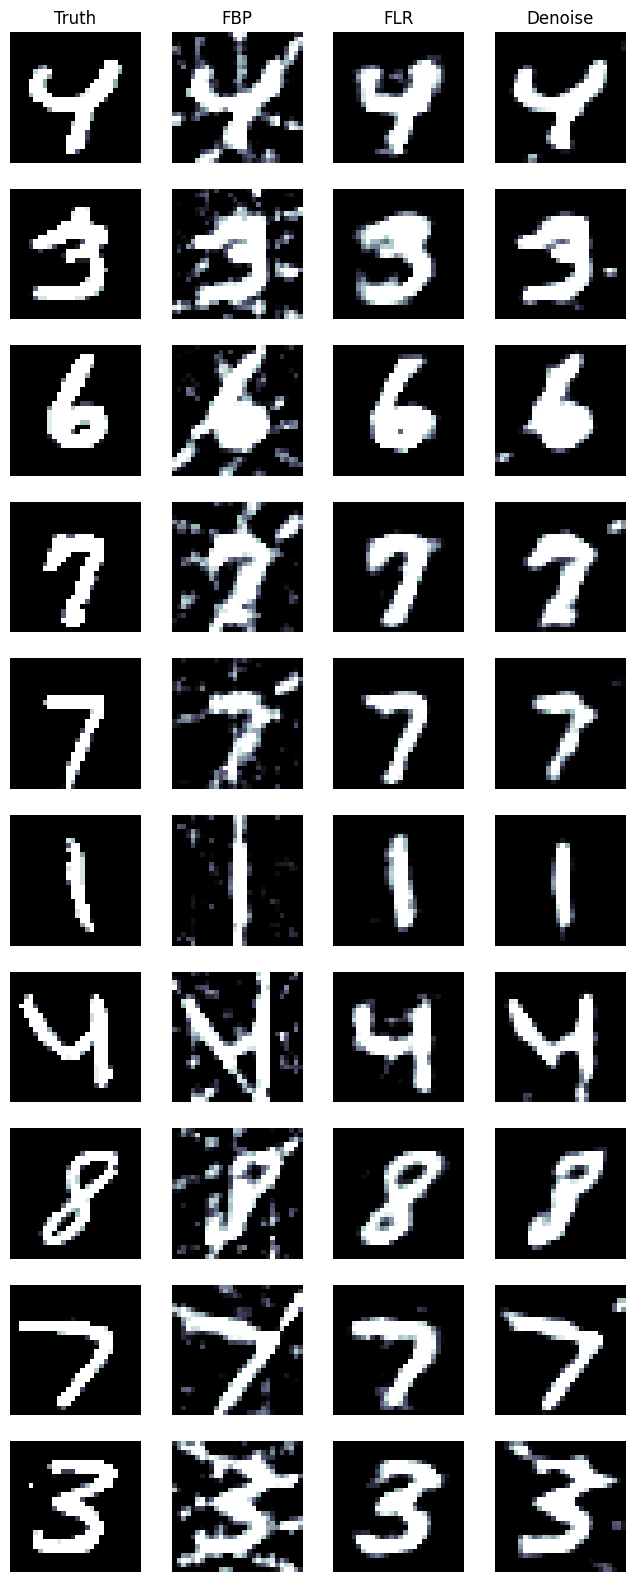

net_sparse 0.998876633986928


In [60]:
test_res_denoise = model2(fbp_op_mod(test_data))
results = [test_images.cpu(), fbp_recos.cpu(), test_res_full.cpu(), test_res_denoise.cpu()]
titles = ['Truth', 'FBP', 'FLR', 'Denoise']
show_image_matrix(results, titles, indices=slice(10, 20), clim=[0, 1], cmap='bone')
print('net_sparse', maf.net_sparsity(model2))

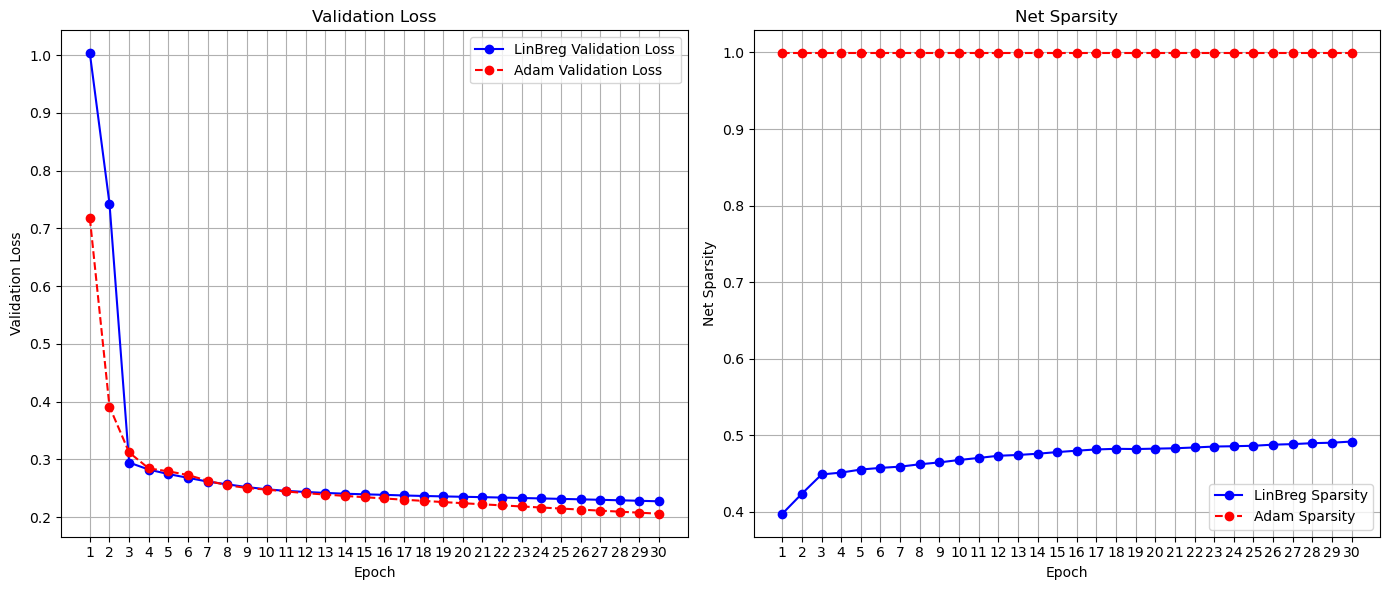

In [7]:
# Load the training results from CSV files
linbreg_results = pd.read_csv('500Samples300Epochs/LinBreg_Denoise_training_results.csv')
adam_results = pd.read_csv('500Samples300Epochs/Adam_Denoise_training_results.csv')

# Extract columns for plotting
epochs_linbreg = linbreg_results['Epoch']
val_loss_linbreg = linbreg_results['Validation Loss']
sparsity_linbreg = linbreg_results['Sparsity']

epochs_adam = adam_results['Epoch']
val_loss_adam = adam_results['Validation Loss']
sparsity_adam = adam_results['Sparsity']

# Create a figure for the plots
plt.figure(figsize=(14, 6))

# Plot 1: Validation Loss vs Epoch
plt.subplot(1, 2, 1)
plt.plot(epochs_linbreg, val_loss_linbreg, marker='o', linestyle='-', color='b', label='LinBreg Validation Loss')
plt.plot(epochs_adam, val_loss_adam, marker='o', linestyle='--', color='r', label='Adam Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.xticks(range(1, max(len(epochs_linbreg), len(epochs_adam)) + 1))  # Set x-ticks to be the epochs
plt.grid()
plt.legend()

# Plot 2: Sparsity vs Epoch
plt.subplot(1, 2, 2)
plt.plot(epochs_linbreg, sparsity_linbreg, marker='o', linestyle='-', color='b', label='LinBreg Sparsity')
plt.plot(epochs_adam, sparsity_adam, marker='o', linestyle='--', color='r', label='Adam Sparsity')
plt.title('Net Sparsity')
plt.xlabel('Epoch')
plt.ylabel('Net Sparsity')
plt.xticks(range(1, max(len(epochs_linbreg), len(epochs_adam)) + 1))  # Set x-ticks to be the epochs
plt.grid()
plt.legend()

plt.tight_layout()
plt.savefig('training_plots_comparison.png')  # Save the figure as a PNG file
plt.show()  # Show the plots

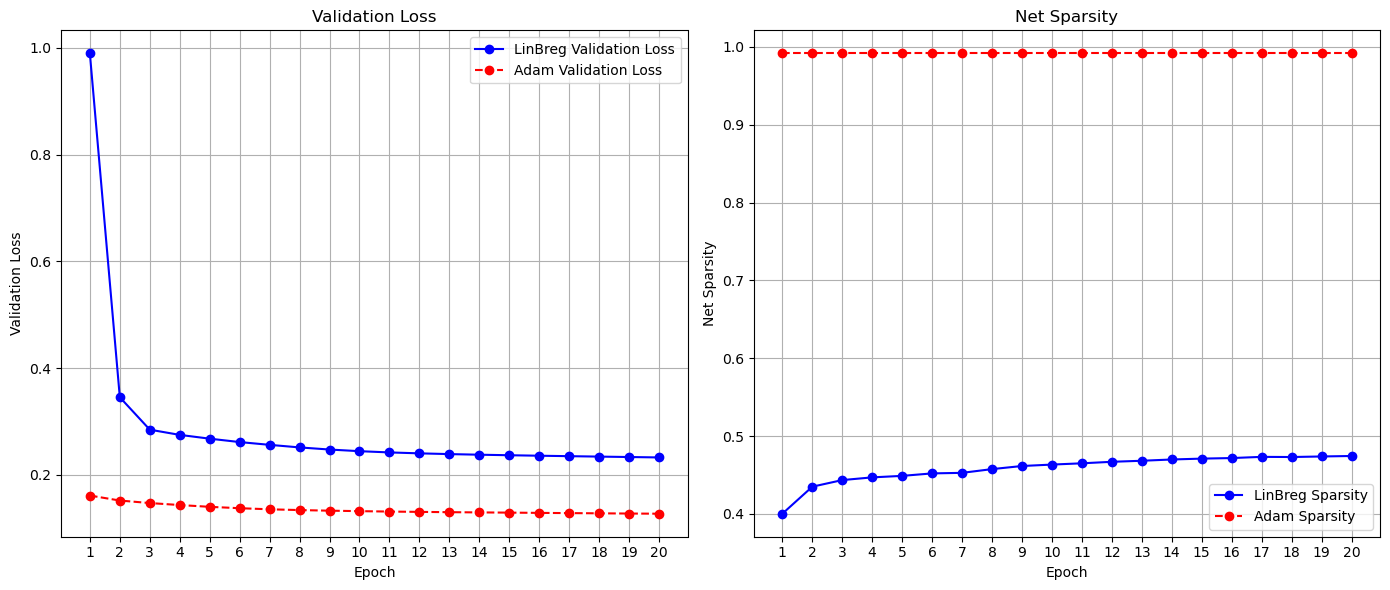

In [8]:
# Load the training results from CSV files
linbreg_results = pd.read_csv('60000Samples20Epochs/LinBreg_Denoise_training_results.csv')
adam_results = pd.read_csv('60000Samples20Epochs/Adam_Denoise_training_results.csv')

# Extract columns for plotting
epochs_linbreg = linbreg_results['Epoch']
val_loss_linbreg = linbreg_results['Validation Loss']
sparsity_linbreg = linbreg_results['Sparsity']

epochs_adam = adam_results['Epoch']
val_loss_adam = adam_results['Validation Loss']
sparsity_adam = adam_results['Sparsity']

# Create a figure for the plots
plt.figure(figsize=(14, 6))

# Plot 1: Validation Loss vs Epoch
plt.subplot(1, 2, 1)
plt.plot(epochs_linbreg, val_loss_linbreg, marker='o', linestyle='-', color='b', label='LinBreg Validation Loss')
plt.plot(epochs_adam, val_loss_adam, marker='o', linestyle='--', color='r', label='Adam Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.xticks(range(1, max(len(epochs_linbreg), len(epochs_adam)) + 1))  # Set x-ticks to be the epochs
plt.grid()
plt.legend()

# Plot 2: Sparsity vs Epoch
plt.subplot(1, 2, 2)
plt.plot(epochs_linbreg, sparsity_linbreg, marker='o', linestyle='-', color='b', label='LinBreg Sparsity')
plt.plot(epochs_adam, sparsity_adam, marker='o', linestyle='--', color='r', label='Adam Sparsity')
plt.title('Net Sparsity')
plt.xlabel('Epoch')
plt.ylabel('Net Sparsity')
plt.xticks(range(1, max(len(epochs_linbreg), len(epochs_adam)) + 1))  # Set x-ticks to be the epochs
plt.grid()
plt.legend()

plt.tight_layout()
plt.savefig('training_plots_comparison.png')  # Save the figure as a PNG file
plt.show()  # Show the plots